# Regression

Note: feature engineering logic adapted from the challenge notebook [https://www.kaggle.com/code/nikitamanaenkov/stock-price-prediction-sample/notebook](https://www.kaggle.com/code/nikitamanaenkov/stock-price-prediction-sample/notebook)

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import SimpleExpSmoothing

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)
from data import download_stock_price_prediction_challenge_data

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


In [2]:
if LOCAL:
    dirfpath = download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices"

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped


## Data Prep and Feature Engineering

In [75]:
def get_ticker_df(ticker_name):
    if 'test' in ticker_name:
        i = int(ticker_name.split('_')[1])
        assert i>=1 and i<=5
        fpath = os.path.join(test_path, f"test_{i}.csv")
    else:
        fpath = os.path.join(train_stocks_path, f"{ticker_name}.csv")
    if not os.path.exists(fpath):
        raise Exception(f"File {fpath} does not exist")
    df = pd.read_csv(fpath)
    return df

def add_indice_features(df_ticker, target):
    # Read index data and merge in a single dataframe
    indices = {
        "dj": "Dow_Jones.csv",
        "nasdaq": "NASDAQ.csv",
        "SP500": "SP500.csv"
    }
    # merged_df = test_dfs[0][['Date', f'return_1', f'close_1', f'volume_1']]
    merged_index_df = df_ticker 
    for i, (key, filename) in enumerate(indices.items()):
        index_df = pd.read_csv(os.path.join(train_indices_path, filename))
        index_df = index_df.rename(columns={f"{target}": f"{target}_{key}"})
        merged_index_df = pd.merge(merged_index_df, index_df[['Date', f'{target}_{key}']], on='Date', how='left')
    # print(f'shape merged_index_df: {merged_index_df.shape}')
    merged_index_df.head()
    return merged_index_df

def prepare_features(df, target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0], lags=1, out_len=500):
    extended_len = out_len + max(ma_windows)-1
    df = df[-extended_len:].copy()
    # print(f'shape of extended df: {df.shape}')
    
    # df['Adjusted_Yesterday'] = df['Adjusted'].shift(1)
    # df['rel_return'] = (df['Adjusted'] - df['Adjusted_Yesterday']) / df['Adjusted_Yesterday']
    df['Volatility'] = (df['High'] - df['Low']) / ((df['High'] + df['Low']) / 2)
    df['Dollar_Vol'] = df['Volume'] * ((df['Open'] + df['Close']) / 2)

    for lag in range(1, lags + 1):
        df[f'{target}_lag{lag}'] = df[target].shift(lag)

    for window in ma_windows:
        df[f'{target}_MA{window}'] = df[target].rolling(window=window).mean()

    # exponential smoothing
    for alpha in ewm_alpha:
        if alpha == 0:
            fit = SimpleExpSmoothing(df[target], initialization_method="estimated").fit()
            print(f'Optimal alpha for exponential smoothing: {fit.params["smoothing_level"]}')
            df[f'{target}_EWMopt'] = fit.fittedvalues
        else:
            df[f'{target}_EWM{alpha}'.replace('.', '')] = df['Returns'].ewm(alpha=alpha).mean()
    

    df['Close_ROC10'] = df['Close'].pct_change(periods=10)

    df.index = pd.to_datetime(df['Date'])

    # rolling correlations with indices
    for index_key in ['dj', 'nasdaq', 'SP500']:
        returns_index_col = f'{target}_{index_key}'
        
        rolling_cov = df[[target, returns_index_col]].rolling(window=beta_window).cov()
        
        cov = rolling_cov.loc[
            rolling_cov.index.get_level_values(1) == returns_index_col, target
            ].reset_index(drop=True)
        cov.index = df.index

        var = df[returns_index_col].rolling(window=beta_window).var()
        var.index = df.index
        
        df[f'Beta{beta_window}_{index_key}'] = cov / var

    cols2drop = ['Date', 'Open', 'High', 'Low', 'Volume', 'Close', 'Adjusted']
    if 'Ticker' in df.columns:
        cols2drop.append('Ticker')
    df.drop(columns=cols2drop, inplace=True)
    df.dropna(inplace=True)
    print(f'shape of final df: {df.shape}')

    return df

In [4]:
target = 'Returns'
df = get_ticker_df('AAPL')
df = add_indice_features(df, target=target)
df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
print(f'shape df: {df.shape}')
# df.head(20)
df.tail(5)

shape of final df: (500, 17)
shape df: (500, 17)


,Returns,Returns_dj,Returns_nasdaq,Returns_SP500,Volatility,Dollar_Vol,Returns_lag1,Returns_MA10,Returns_MA20,Returns_MA60,Returns_EWM01,Returns_EWM03,Returns_EWM05,Close_ROC10,Beta10_dj,Beta10_nasdaq,Beta10_SP500
Date,,,,,,,,,,,,,,,,,
2025-03-17,0.002389,0.008519,0.003074,0.006416,0.024695,1.027112e+10,0.018171,-0.010371,-0.006507,-0.002482,-0.006760,-0.006493,-0.001129,-0.100954,1.376426,0.758114,1.095920
2025-03-18,-0.006121,-0.006222,-0.017101,-0.010654,0.017157,9.056135e+09,0.002389,-0.010101,-0.006787,-0.002746,-0.006696,-0.006381,-0.003625,-0.098504,1.537605,0.707538,1.101382
2025-03-19,0.011989,0.009219,0.014092,0.010798,0.023167,1.167818e+10,-0.006121,-0.008821,-0.006269,-0.002189,-0.004827,-0.000870,0.004182,-0.086960,1.705000,0.770495,1.192421
2025-03-20,-0.005296,-0.000269,-0.003333,-0.002185,0.024528,1.045886e+10,0.011989,-0.009177,-0.006730,-0.002394,-0.004874,-0.002198,-0.000557,-0.090214,1.845263,0.942093,1.428337
2025-03-21,0.019477,0.000763,0.005224,0.000825,0.035153,2.022948e+10,-0.005296,-0.008818,-0.005699,-0.002383,-0.002439,0.004304,0.009460,-0.087004,1.822981,0.944766,1.401109


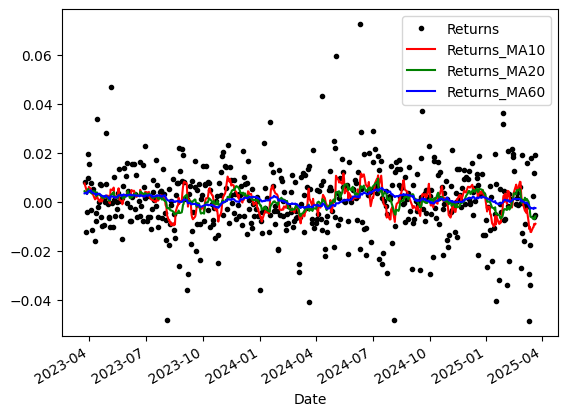

In [5]:
df[f'{target}'].plot(style='.', color='black')
df[f'{target}_MA10'].plot(style='-', color='red')
df[f'{target}_MA20'].plot(style='-', color='green')
df[f'{target}_MA60'].plot(style='-', color='blue')
plt.legend()
plt.show()


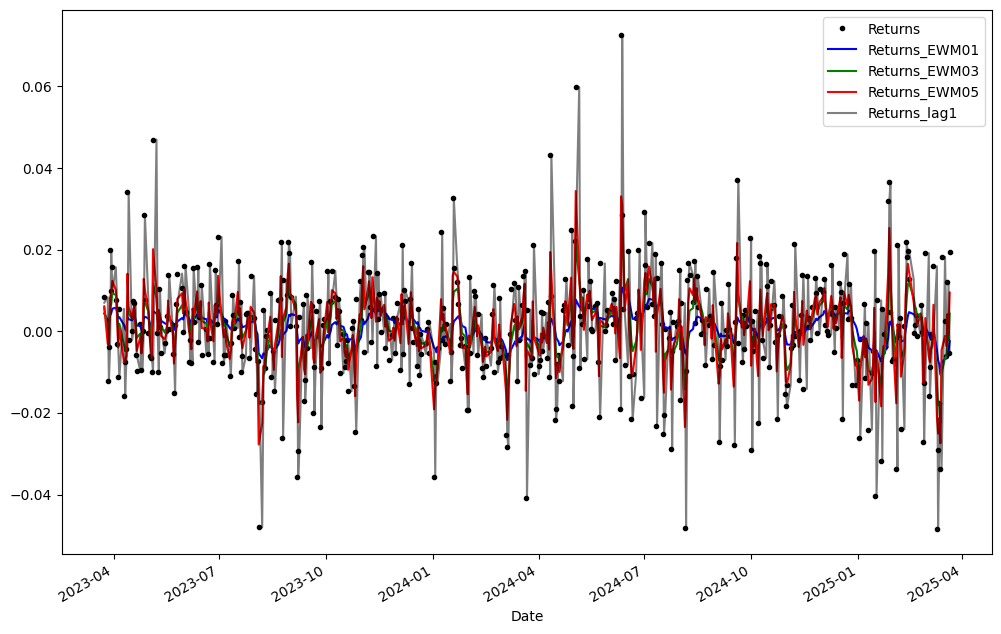

In [6]:
plt.figure(figsize=(12, 8))
df[f'{target}'].plot(style='.', color='black')
df[f'{target}_EWM01'].plot(style='-', color='blue')
df[f'{target}_EWM03'].plot(style='-', color='green')
df[f'{target}_EWM05'].plot(style='-', color='red')
df[f'{target}_lag1'].plot(style='-', color='black', alpha=0.5)
plt.legend()
plt.show()

## Model Training and Testing

### Predicting the current day returns

In [7]:
# train test split
def split_df(df, train_ratio=0.8):
    # df.drop(columns=['Close'], inplace=True)
    all_days = pd.Series(df.index.sort_values().values)
    split_date = all_days[int(len(all_days) * train_ratio)]
    train_df = df[df.index < split_date].copy()
    test_df  = df[df.index >=  split_date].copy()
    print(f'Train shape: {train_df.shape}, Test shape: {test_df.shape}')
    return train_df, test_df

def get_X_y(df, target='Returns', forecast_horizon=1):
    y = df[target]
    X = df.drop(columns=[target])
    print(f'X shape: {X.shape}, y shape: {y.shape}')    
    return X, y

def evaluate(y_train, y_hat_train, y_test, y_hat_test):
    rmse_train = root_mean_squared_error(y_train, y_hat_train)
    print(f'Training RMSE: {rmse_train:.5f}')
    rmse_test = root_mean_squared_error(y_test, y_hat_test)
    print(f'Test RMSE: {rmse_test:.5f}')

    fig, ax = plt.subplots(figsize=(12, 8))
    y_train.plot(style=".", color='blue', label='y_train', ax=ax)
    y_test.plot(style=".", color='red', label='y_test', ax=ax)
    y_hat_train.plot(style='-', color='blue', label='y_train_pred', ax=ax)
    y_hat_test.plot(style='-', color='red', label='y_test_pred', ax=ax)
    plt.legend()
    plt.show()

In [8]:
train_df, test_df = split_df(df, train_ratio=0.8)
X_train, y_train = get_X_y(train_df, target='Returns')
X_test, y_test = get_X_y(test_df, target='Returns')

Train shape: (400, 17), Test shape: (100, 17)
X shape: (400, 16), y shape: (400,)
X shape: (100, 16), y shape: (100,)


In [12]:
X_test.tail(6)

,Returns_dj,Returns_nasdaq,Returns_SP500,Volatility,Dollar_Vol,Returns_lag1,Returns_MA10,Returns_MA20,Returns_MA60,Returns_EWM01,Returns_EWM03,Returns_EWM05,Close_ROC10,Beta10_dj,Beta10_nasdaq,Beta10_SP500
Date,,,,,,,,,,,,,,,,
2025-03-14,0.016529,0.026069,0.021266,0.020636,1.276505e+10,-0.033644,-0.012185,-0.005991,-0.002326,-0.007776,-0.010299,-0.004648,-0.117226,1.337316,0.678118,1.019381
2025-03-17,0.008519,0.003074,0.006416,0.024695,1.027112e+10,0.018171,-0.010371,-0.006507,-0.002482,-0.006760,-0.006493,-0.001129,-0.100954,1.376426,0.758114,1.095920
2025-03-18,-0.006222,-0.017101,-0.010654,0.017157,9.056135e+09,0.002389,-0.010101,-0.006787,-0.002746,-0.006696,-0.006381,-0.003625,-0.098504,1.537605,0.707538,1.101382
2025-03-19,0.009219,0.014092,0.010798,0.023167,1.167818e+10,-0.006121,-0.008821,-0.006269,-0.002189,-0.004827,-0.000870,0.004182,-0.086960,1.705000,0.770495,1.192421
2025-03-20,-0.000269,-0.003333,-0.002185,0.024528,1.045886e+10,0.011989,-0.009177,-0.006730,-0.002394,-0.004874,-0.002198,-0.000557,-0.090214,1.845263,0.942093,1.428337
2025-03-21,0.000763,0.005224,0.000825,0.035153,2.022948e+10,-0.005296,-0.008818,-0.005699,-0.002383,-0.002439,0.004304,0.009460,-0.087004,1.822981,0.944766,1.401109


Training RMSE: 0.00136
Test RMSE: 0.00153


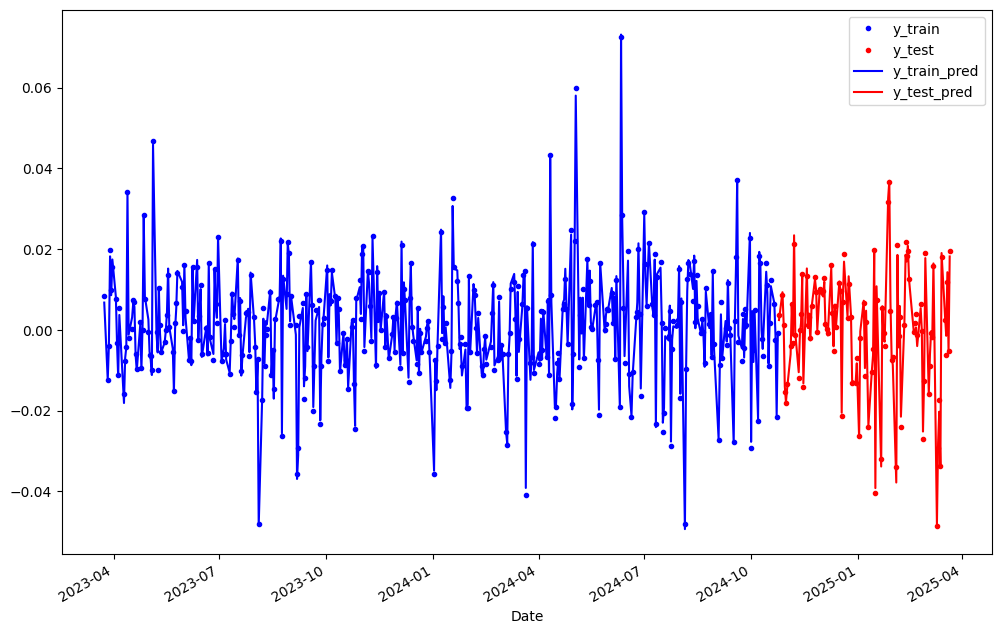

In [9]:
cols2scale = ['Dollar_Vol']
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), cols2scale),
    ],
    remainder='passthrough'
)
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('preprocessor', Preprocessor),
        ('model', model)
        ]
        )

pipeline.fit(X_train, y_train)
y_hat_train = pd.Series(pipeline.predict(X_train), index=y_train.index)
y_hat_test = pd.Series(pipeline.predict(X_test), index=y_test.index)

evaluate(y_train, y_hat_train, y_test, y_hat_test)

### Predicting the next 10 days: Multioutput

In [ ]:
def make_multistep_target(y, steps):
    y_multi = pd.concat(
        {f'y_step_{i + 1}': y.shift(-i)
         for i in range(steps)},
        axis=1
        )
    y_multi.dropna(inplace=True)
    return y_multi

def get_X_y_multistep(df, steps=11, target='Returns', forecast_horizon=1):
    y = df[target]
    y_multi = make_multistep_target(y, steps=steps).dropna()
    X = df.drop(columns=[target])
    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y_multi, X = y_multi.align(X, join='inner', axis=0)
    print(f'X shape: {X.shape}, y_multi shape: {y_multi.shape}')
    return X, y_multi


In [130]:
target = 'Returns'
df = get_ticker_df('AAPL')
df = add_indice_features(df, target=target)
df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = split_df(df, train_ratio=0.8)
X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


In [131]:
# X_test.tail()
y_test.tail()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11
Date,,,,,,,,,,,
2025-03-03,-0.015754,-0.008822,-0.000805,-0.001739,0.015893,-0.048480,-0.029189,-0.017479,-0.033644,0.018171,0.002389
2025-03-04,-0.008822,-0.000805,-0.001739,0.015893,-0.048480,-0.029189,-0.017479,-0.033644,0.018171,0.002389,-0.006121
2025-03-05,-0.000805,-0.001739,0.015893,-0.048480,-0.029189,-0.017479,-0.033644,0.018171,0.002389,-0.006121,0.011989
2025-03-06,-0.001739,0.015893,-0.048480,-0.029189,-0.017479,-0.033644,0.018171,0.002389,-0.006121,0.011989,-0.005296
2025-03-07,0.015893,-0.048480,-0.029189,-0.017479,-0.033644,0.018171,0.002389,-0.006121,0.011989,-0.005296,0.019477


In [132]:
cols2scale = ['Dollar_Vol']
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), cols2scale),
    ],
    remainder='passthrough'
)
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('preprocessor', Preprocessor),
        ('model', model)
        ]
        )
pipeline.fit(X_train, y_train)
y_hat_train = pd.DataFrame(pipeline.predict(X_train), index=y_train.index, columns=y_train.columns)
y_hat_test = pd.DataFrame(pipeline.predict(X_test), index=y_test.index, columns=y_test.columns)

In [133]:
y_hat_test.tail()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11
Date,,,,,,,,,,,
2025-03-03,-0.015785,0.000588,0.002238,0.007723,-0.000087,0.004402,0.005354,0.002904,0.004821,0.001632,0.004026
2025-03-04,-0.006054,0.005496,0.003723,-0.000765,0.004253,0.004243,0.006762,-0.000711,0.001166,0.005974,0.004895
2025-03-05,-0.000271,0.002789,0.003886,0.003332,0.005739,0.006293,-0.002571,0.000240,0.001219,0.003379,0.004616
2025-03-06,-0.001889,0.000689,-0.000196,0.005402,-0.000368,0.000594,0.004382,0.001372,0.003714,0.002539,0.007197
2025-03-07,0.016450,0.003159,0.002135,0.004074,0.004804,0.003140,0.001370,0.002765,0.002251,0.002679,0.004666


In [34]:
import seaborn as sns

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


def evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test):
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}"))

    plt.rc("figure", autolayout=True, figsize=(12, 6))
    plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=16,
        titlepad=10,
    )

    plot_params = dict(
        color="0.75",
        style=".-",
        markeredgecolor="0.25",
        markerfacecolor="0.25",
    )
    palette = dict(palette='husl', n_colors=64)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    ax1 = df[target][y_hat_train.index].plot(**plot_params, ax=ax1)
    ax1 = plot_multistep(y_hat_train, ax=ax1, palette_kwargs=palette)
    _ = ax1.legend([f'{target} (train)', 'Forecast'])
    ax2 = df[target][y_hat_test.index].plot(**plot_params, ax=ax2)
    ax2 = plot_multistep(y_hat_test, ax=ax2, palette_kwargs=palette)
    _ = ax2.legend([f'{target} (test)', 'Forecast'])

Train RMSE: 0.01226
Test RMSE: 0.01451


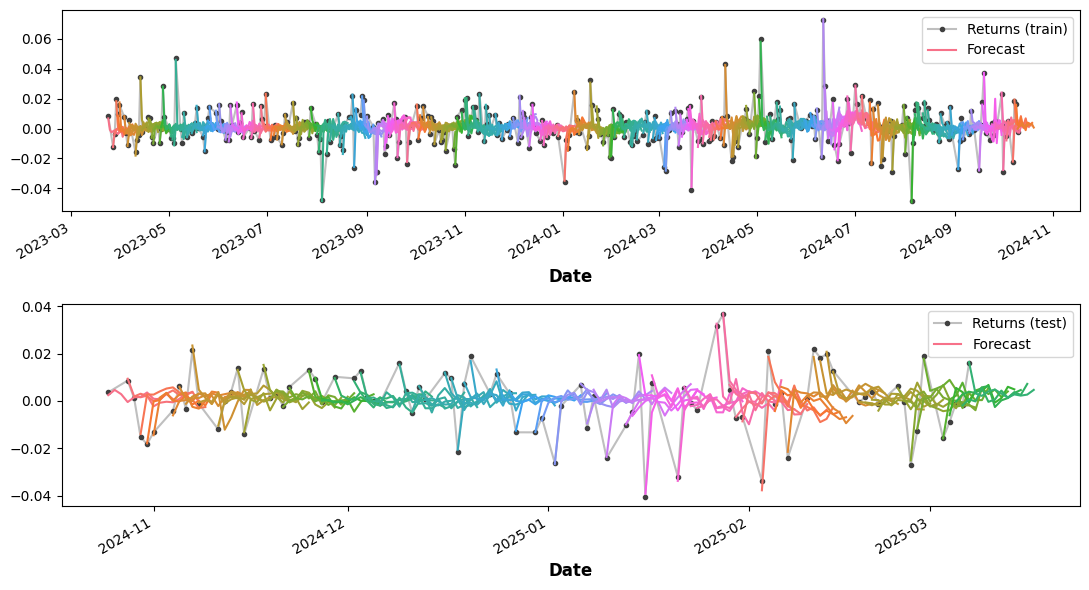

In [134]:
evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test)

### Predicting the next 10 days: Regressor Chain

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01226
Test RMSE: 0.01451


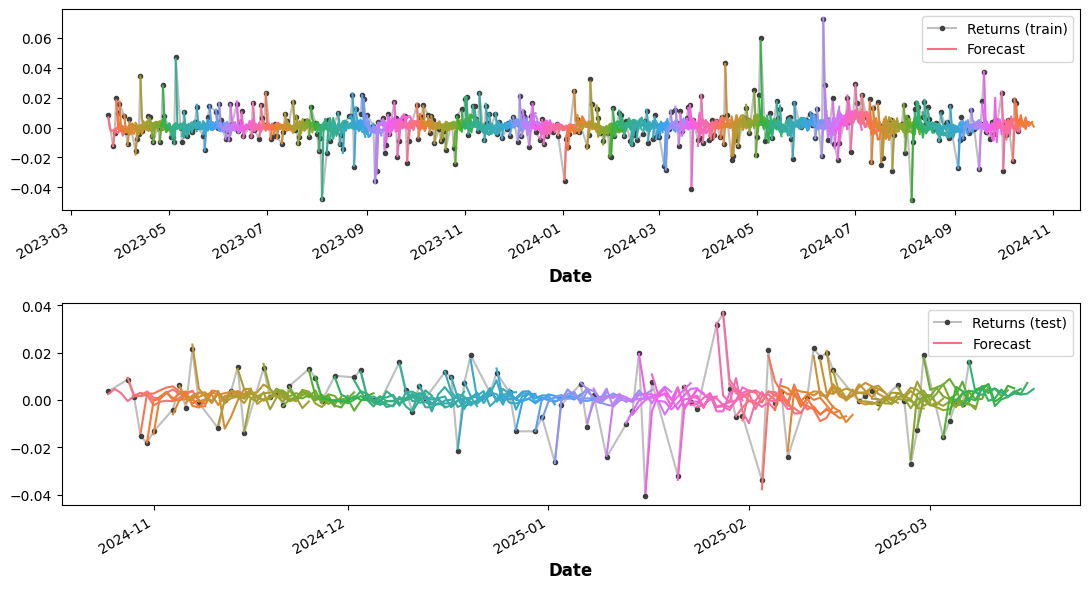

In [135]:
from sklearn.multioutput import RegressorChain
cols2scale = ['Dollar_Vol']
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), cols2scale),
    ],
    remainder='passthrough'
)
base_model  = LinearRegression()
model_chain = RegressorChain(estimator=base_model, order=None)
pipeline_modelchain = Pipeline(
    steps=[
        ('preprocessor', Preprocessor),
        ('model', model_chain)
        ]
        )
target = 'Returns'
df = get_ticker_df('AAPL')
df = add_indice_features(df, target=target)
df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = split_df(df, train_ratio=0.8)
X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')
pipeline_modelchain.fit(X_train, y_train)
y_hat_train = pd.DataFrame(pipeline_modelchain.predict(X_train), index=y_train.index, columns=y_train.columns)
y_hat_test = pd.DataFrame(pipeline_modelchain.predict(X_test), index=y_test.index, columns=y_test.columns)
evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test)

## Training and forecasting for the test set

In [ ]:
# Helper functions

def make_forecast(df):
    X_pred = df.iloc[[-1], :]
    X_pred = X_pred.drop(columns=[target])
    y_pred = pipeline.predict(X_pred)
    y_pred = pd.DataFrame(y_pred, index=X_pred.index, columns=y_test.columns)
    return y_pred

def create_submission_file(forecasts, test_files, fnamesuffix=''):
    if LOCAL:
        fpath = os.path.join(rootpath, 'data', 'stock-price-prediction-challenge', 'sample_submission.csv')
    else:
        fpath = '/kaggle/input/stock-price-prediction-challenge/sample_submission.csv'
    sample_submission = pd.read_csv(fpath)
    # sample_submission
    dates_from_sample = sample_submission['Date']

    submission_df = pd.DataFrame(dates_from_sample, columns=['Date'])

    for test_file in test_files:
        predictions = forecasts[test_file].iloc[:, -10:].values.reshape(-1, 1)
        test_no = test_file.split('_')[1]
        col = f'Returns_{test_no}'
        submission_df[col] = predictions
    from datetime import datetime
    now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    fpath = f'Regression_submission{fnamesuffix}_{now}.csv'
    submission_df.to_csv(fpath, index=False)
    print(f'Submission file created: {fpath}')

### Multioutput

In [147]:
def build_pipeline():
    cols2scale = ['Dollar_Vol']
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), cols2scale),
        ],
        remainder='passthrough'
    )
    model = LinearRegression()
    pipeline = Pipeline(
        steps=[
            ('preprocessor', Preprocessor),
            ('model', model)
            ]
            )
    return pipeline

In [144]:
forecasts = {}
train_rmse_list = []
test_rmse_list = []
test_files= ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
for test_file in test_files:
    print('Training and Forecasting for:', test_file)
    target = 'Returns'
    df = get_ticker_df(test_file)
    df = add_indice_features(df, target=target)
    df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)

    train_df, test_df = split_df(df, train_ratio=0.8)
    X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
    X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')

    pipeline = build_pipeline()
    pipeline.fit(X_train, y_train)

    y_hat_train = pd.DataFrame(pipeline.predict(X_train), index=y_train.index, columns=y_train.columns)
    y_hat_test = pd.DataFrame(pipeline.predict(X_test), index=y_test.index, columns=y_test.columns)
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}\n"))
    forecast = make_forecast(df)
    forecasts[test_file] = forecast

avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
print(f'Average Train RMSE: {avg_train_rmse:.5f}, Average Test RMSE: {avg_test_rmse:.5f}')


Training and Forecasting for: test_1
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.02496
Test RMSE: 0.02212

Training and Forecasting for: test_2
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01080
Test RMSE: 0.01289

Training and Forecasting for: test_3
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01334
Test RMSE: 0.01876

Training and Forecasting for: test_4
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.03127
Test RMSE: 0.02595

Training and Forecasting for: test_5
sha

In [149]:
create_submission_file(forecasts, test_files, fnamesuffix='_LReg_MultiOut')

Submission file created: Regression_submission_LReg_MultiOut_2025-07-16_11-16-11.csv


### Regressor Chain

In [ ]:
from sklearn.multioutput import RegressorChain
def build_pipeline_modelchain():
    cols2scale = ['Dollar_Vol']
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), cols2scale),
        ],
        remainder='passthrough'
    )
    base_model  = LinearRegression()
    model_chain = RegressorChain(estimator=base_model, order=None)
    pipeline_modelchain = Pipeline(
        steps=[
            ('preprocessor', Preprocessor),
            ('model', model_chain)
            ]
            )
    return pipeline_modelchain

In [148]:
forecasts = {}
train_rmse_list = []
test_rmse_list = []
test_files= ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
for test_file in test_files:
    print('Training and Forecasting for:', test_file)
    target = 'Returns'
    df = get_ticker_df(test_file)
    df = add_indice_features(df, target=target)
    df = prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)

    train_df, test_df = split_df(df, train_ratio=0.8)
    X_train, y_train = get_X_y_multistep(train_df, steps=11, target='Returns')
    X_test, y_test = get_X_y_multistep(test_df, steps=11, target='Returns')

    pipeline = build_pipeline_modelchain()
    pipeline.fit(X_train, y_train)

    y_hat_train = pd.DataFrame(pipeline.predict(X_train), index=y_train.index, columns=y_train.columns)
    y_hat_test = pd.DataFrame(pipeline.predict(X_test), index=y_test.index, columns=y_test.columns)
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}\n"))
    forecast = make_forecast(df)
    forecasts[test_file] = forecast
avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
print(f'Average Train RMSE: {avg_train_rmse:.5f}, Average Test RMSE: {avg_test_rmse:.5f}')

Training and Forecasting for: test_1
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.02496
Test RMSE: 0.02212

Training and Forecasting for: test_2
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01080
Test RMSE: 0.01289

Training and Forecasting for: test_3
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.01334
Test RMSE: 0.01876

Training and Forecasting for: test_4
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
Train RMSE: 0.03127
Test RMSE: 0.02595

Training and Forecasting for: test_5
sha

No noticeable difference, so no need to create a new submission file